In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [3]:
train = pd.read_csv('./data/train_clean.csv')
train.head()

,posts_combined,subreddit,is_tv,clean_text,stemmed_text,lemmed_text,pnouns_from_lemmed
0,Official Discussion Weekly Megathread (Pet Sem...,movies,0,official discussion weekly megathread pet sema...,offici discuss weekli megathread ( pet sematar...,Official Discussion Weekly Megathread Pet Sema...,Discussion Weekly Megathread Pet Sematary Shaz...
1,"Twenty years ago, an upstart animator named Mi...",movies,0,twenty years ago upstart animator named mike j...,"twenti year ago , an upstart anim name mike ju...",Twenty Mike Judge At Office Space,Mike Judge Office
2,10 years later and Avatar still holds the reco...,movies,0,years later avatar still holds record highest ...,10 year later and avatar still hold the record...,Avatar,NaN
3,‘Hellboy’ Receives Rare R 18+ Rating in Austra...,movies,0,hellboy receives rare r rating australia stron...,‘ hellboy ’ receiv rare R 18+ rate in australi...,Hellboy Receives Rare Rating Australia Strong ...,Hellboy Rare Rating Australia Strong Bloody Vi...
4,"In 2015, Maggie Gyllenhaal, then 37, was told ...",movies,0,maggie gyllenhaal told old play love interest ...,"In 2015 , maggi gyllenha , then 37 , wa told s...",In Maggie Gyllenhaal Any,Maggie Gyllenhaal Any


## Training the Model

### Baseline Score (Accuracy)

In [4]:
# returns the 
train['is_tv'].value_counts(normalize=True)

1    0.644347
0    0.355653
Name: is_tv, dtype: float64

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [33]:
def classifier(X, y, estimator, random_state, text, pipe_params):
    
    '''
    A function that takes 5 arguments: an n x 1 predictor vector, 
    an n x 1 target vector, an estimator, sets a random state, 
    a doctionary of hyper-parameters, and the title of the ROC curve.
    
    It trains tests splits the data, uses a pipeline, performs a
    grid search for optimal hyperparameters, calculates evaluation
    metrics and returns a classification report and an roc-auc curve.
    '''
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = .40, 
                                                        stratify=y,
                                                       random_state=random_state)
    
    
    pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('clf', estimator)
    ])


    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)

    gs.fit(X_train, y_train)

    #print(f'The Accuracy score is: {round(gs.score(X_train, y_train), 2)}')

    print(gs.best_params_)
    print(f'The cross_val_score is: {round(gs.best_score_, 2)}')
    #y_predpr_lr = gs.best_estimator_.predict_proba(X_test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test, gs.best_estimator_.predict(X_test)).ravel()



    accuracy = round((tn + tp) / (tn + fp + fn + tp), 2)
    misclassification = round((1 - accuracy), 2)
    sensitivity = round((tp) / (tp + fn), 2)
    specificity = round((tn) / (tn + fp), 2)
    precision = round((tp) / (tp + fp), 2)

    print(f'The Accuracy is: {accuracy}')
    print(f'The Missclassification Rate is: {misclassification}')
    print(f'The Sensitivity/Recall is: {sensitivity}')
    print(f'The Specificity is: {specificity}')
    print(f'The Precision is: {precision}')


    fpr_clf, tpr_clf, _ = roc_curve(y_test, gs.best_estimator_.predict_proba(X_test)[:, 1])
    roc_auc_clf = auc(fpr_clf, tpr_clf)

    plt.figure(figsize = (10, 7))
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr_clf, tpr_clf, lw=3, label='The ROC curve (area = {:0.2f})'.format(roc_auc_clf))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(f'ROC curve {(text)}', fontsize=18)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

    return print(classification_report(y_test, gs.best_estimator_.predict(X_test)))


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'tvec__max_features': 300, 'tvec__ngram_range': (1, 3)}
The cross_val_score is: 0.82
The Accuracy is: 0.83
The Missclassification Rate is: 0.17
The Sensitivity/Recall is: 0.95
The Specificity is: 0.62
The Precision is: 0.82
              precision    recall  f1-score   support

           0       0.88      0.62      0.73       293
           1       0.82      0.95      0.88       532

   micro avg       0.83      0.83      0.83       825
   macro avg       0.85      0.79      0.80       825
weighted avg       0.84      0.83      0.83       825



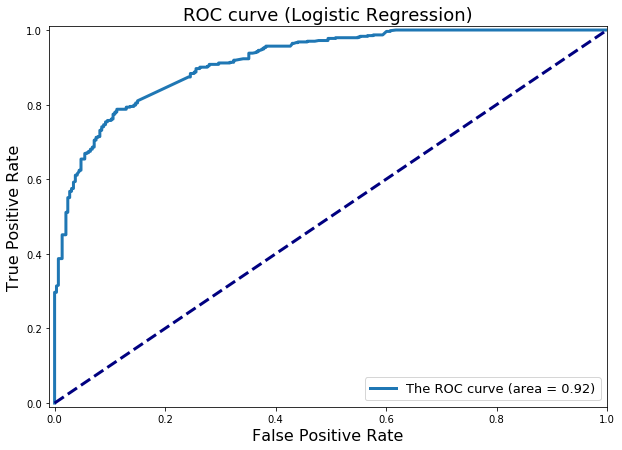

In [34]:
classifier(train['clean_text'], train['is_tv'], 
           LogisticRegression(), 
           random_state=20720,
          text='(Logistic Regression)', pipe_params = 
           {'tvec__ngram_range': [(1, 2), (1, 3), (2,3)],
            'tvec__max_features': [200, 300, 500]}
          )

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

{'clf__learning_rate': 0.4, 'clf__max_depth': 6, 'clf__n_estimators': 150, 'tvec__max_features': 500, 'tvec__ngram_range': (1, 2)}
The cross_val_score is: 0.85
The Accuracy is: 0.88
The Missclassification Rate is: 0.12
The Sensitivity/Recall is: 0.94
The Specificity is: 0.75
The Precision is: 0.87
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       293
           1       0.87      0.94      0.91       532

   micro avg       0.88      0.88      0.88       825
   macro avg       0.88      0.85      0.86       825
weighted avg       0.88      0.88      0.87       825



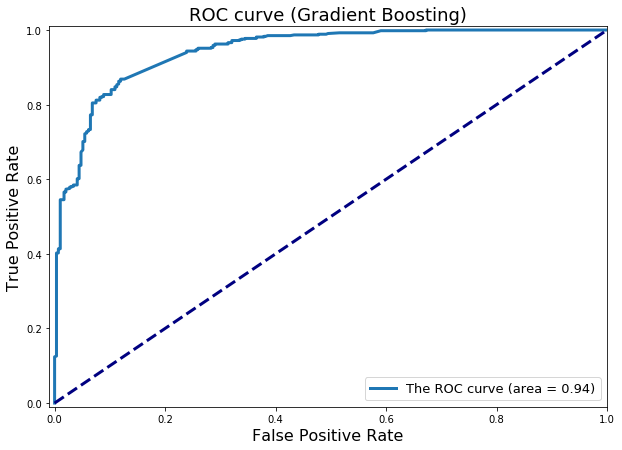

In [44]:
classifier(train['clean_text'], train['is_tv'], 
           GradientBoostingClassifier(warm_start=True), 
           random_state=20720,
           text='(Gradient Boosting)', pipe_params = 
           {'tvec__ngram_range': [(1, 2), (1, 3), (2, 3)],
            'tvec__max_features': [200, 300, 500],
            'clf__n_estimators': [100, 150, 200],
           'clf__learning_rate': [0.2, 0.4, 0.6],
           'clf__max_depth': [4, 6, 8]}
          )

In [45]:
from sklearn.svm import SVC

{'clf__gamma': 'auto', 'clf__kernel': 'linear', 'tvec__max_features': 500, 'tvec__ngram_range': (1, 3)}
The cross_val_score is: 0.82
The Accuracy is: 0.84
The Missclassification Rate is: 0.16
The Sensitivity/Recall is: 0.92
The Specificity is: 0.68
The Precision is: 0.84
              precision    recall  f1-score   support

           0       0.83      0.68      0.75       293
           1       0.84      0.92      0.88       532

   micro avg       0.84      0.84      0.84       825
   macro avg       0.83      0.80      0.81       825
weighted avg       0.84      0.84      0.83       825



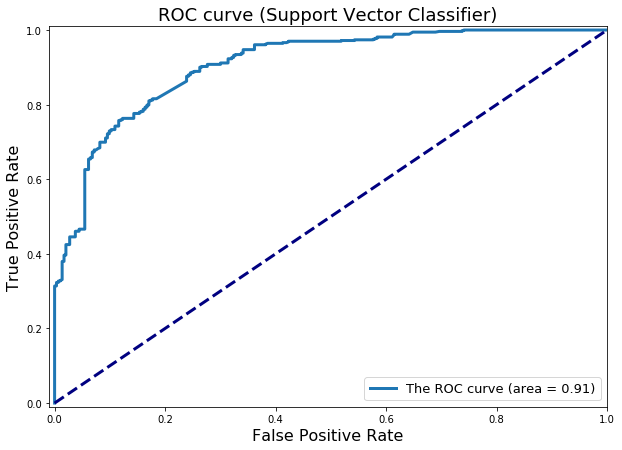

In [47]:
classifier(train['clean_text'], train['is_tv'],
          SVC(probability=True), random_state=20720,
          text='(Support Vector Classifier)',
          pipe_params = {
    'tvec__ngram_range': [(1, 2), (1, 3), (2, 3)],
    'tvec__max_features': [200, 300, 500],
    'clf__kernel': ['rbf', 'sigmoid', 'linear'],
    'clf__gamma': ['auto', 'scale']
    })